In [2]:

import os, math, warnings
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    mean_absolute_error, mean_absolute_percentage_error,
    root_mean_squared_error, r2_score
)
import joblib
warnings.filterwarnings("ignore")

In [3]:
# -------------------------------------------------------
# 1️⃣ Helper functions
# -------------------------------------------------------
def _lower_cols(df):
    df = df.copy()
    df.columns = [c.strip().replace(" ", "_").lower() for c in df.columns]
    return df

def _parse_date(x):
    if pd.isna(x): return np.nan
    try: return pd.to_datetime(x, errors="coerce")
    except: return np.nan

def safe_div(a,b,default=0.0):
    try: return float(a)/float(b) if b and not pd.isna(b) else default
    except: return default

def coalesce(*vals):
    for v in vals:
        if v is not None and not (isinstance(v,float) and np.isnan(v)): return v
    return np.nan

In [4]:
# -------------------------------------------------------
# 2️⃣ Load & merge datasets
# -------------------------------------------------------
PROJECTS = {
    "Aurora": {
        "issues":  r"PM_Kaggle_dataset\AgileScrumSprintVelocityDataSet\Agile Scrum Dataset\Finalized Datasets for Aurora Project\Aurora Issues 554.csv",
        "summary": r"PM_Kaggle_dataset\AgileScrumSprintVelocityDataSet\Agile Scrum Dataset\Finalized Datasets for Aurora Project\Aurora Issues summery 568.csv",
        "sprints": r"PM_Kaggle_dataset\AgileScrumSprintVelocityDataSet\Agile Scrum Dataset\Finalized Datasets for Aurora Project\Aurora Sprints 41.csv",
    },
    "Meso": {
        "issues":  r"PM_Kaggle_dataset\AgileScrumSprintVelocityDataSet\Agile Scrum Dataset\Finalized Datasets for Meso Project\Mesos Stories 176.csv",
        "summary": r"PM_Kaggle_dataset\AgileScrumSprintVelocityDataSet\Agile Scrum Dataset\Finalized Datasets for Meso Project\MESO Issue Summary 370.csv",
        "sprints": r"PM_Kaggle_dataset\AgileScrumSprintVelocityDataSet\Agile Scrum Dataset\Finalized Datasets for Meso Project\MESO Sprint 96.csv",
    },
    "SpringXD": {
        "issues":  r"PM_Kaggle_dataset\AgileScrumSprintVelocityDataSet\Agile Scrum Dataset\Finalized Datasets for Spring XD Project by Randula\Spring XD Issues 1992.csv",
        "summary": r"PM_Kaggle_dataset\AgileScrumSprintVelocityDataSet\Agile Scrum Dataset\Finalized Datasets for Spring XD Project by Randula\Spring XD Issues Summary 2861.csv",
        "sprints": r"PM_Kaggle_dataset\AgileScrumSprintVelocityDataSet\Agile Scrum Dataset\Finalized Datasets for Spring XD Project by Randula\Spring XD Sprints 67.csv",
    },
    "UserGrid": {
        "issues":  r"PM_Kaggle_dataset\AgileScrumSprintVelocityDataSet\Agile Scrum Dataset\Finalized Datasets for UserGrid\Usergrid Issues 824.csv",
        "summary": r"PM_Kaggle_dataset\AgileScrumSprintVelocityDataSet\Agile Scrum Dataset\Finalized Datasets for UserGrid\Usergrid Issues Summary 929.csv",
        "sprints": r"PM_Kaggle_dataset\AgileScrumSprintVelocityDataSet\Agile Scrum Dataset\Finalized Datasets for UserGrid\Usergrid Sprints 36.csv",
    },
}

# -----------------------------
# 3️⃣ LOAD & MERGE ALL PROJECTS (verified)
# -----------------------------
combined = []

for pname, p in PROJECTS.items():
    print(f"\n🔄 Loading {pname} ...")

    # Load files
    iss = _lower_cols(pd.read_csv(p["issues"], on_bad_lines="skip", engine="python"))
    summ = _lower_cols(pd.read_csv(p["summary"], on_bad_lines="skip", engine="python"))
    spr  = _lower_cols(pd.read_csv(p["sprints"], on_bad_lines="skip", engine="python"))

    # Normalize naming
    rename_map = {"priority": "priorityid", "priority_id": "priorityid", "storypoints": "storypoint"}
    for df_ in [iss, summ, spr]:
        df_.rename(columns={k: v for k, v in rename_map.items() if k in df_.columns}, inplace=True)

    # Normalize key casing (to ensure matches)
    if "key" in iss.columns:
        iss["key"] = iss["key"].astype(str).str.strip().str.upper()
    if "issuekey" in summ.columns:
        summ["issuekey"] = summ["issuekey"].astype(str).str.strip().str.upper()

    # Parse sprint dates
    for c in ["sprintstartdate", "sprintenddate", "sprintcompletedate"]:
        if c in spr.columns:
            spr[c] = spr[c].apply(_parse_date)

    if "sprintlength" not in spr.columns and {"sprintstartdate","sprintenddate"} <= set(spr.columns):
        spr["sprintlength"] = (spr["sprintenddate"] - spr["sprintstartdate"]).dt.days.clip(lower=1)
    spr["velocity_sp_per_day"] = spr.apply(
        lambda r: safe_div(r.get("completedissuescount", 0), r.get("sprintlength", 0)), axis=1
    )

    # --- Merge summary + sprints ---
    join = summ.merge(spr, on="sprintid", how="left", suffixes=("", "_spr"))

    # --- Merge summary + issues (✅ correct join: issuekey ↔ key) ---
    if "issuekey" in join.columns and "key" in iss.columns:
        join = join.merge(
            iss[
                [c for c in ["key", "issuetype", "status", "storypoint", "priorityid"]
                 if c in iss.columns]
            ],
            left_on="issuekey",
            right_on="key",
            how="left",
            suffixes=("", "_issue")
        )
    else:
        print(f"⚠️ {pname}: missing 'issuekey' or 'key' for merge.")
        continue

    # Unify columns
    join["priorityid"] = join["priorityid"].combine_first(join.get("priorityid_issue"))
    join["storypoint"] = join.get("currentstorypoint", np.nan).combine_first(
        join.get("initialstorypoint", np.nan)
    ).combine_first(join.get("storypoint", np.nan))

    join["project"] = pname
    combined.append(join)
    print(f"✅ Loaded {pname}: {join.shape}")

if not combined:
    raise RuntimeError("❌ No project data loaded — check file paths above.")

df = pd.concat(combined, ignore_index=True)
print("\n✅ Combined all projects → shape:", df.shape)
print(df[["project", "issuetype", "storypoint", "priorityid"]].head(10))



🔄 Loading Aurora ...
✅ Loaded Aurora: (910, 38)

🔄 Loading Meso ...
✅ Loaded Meso: (819, 38)

🔄 Loading SpringXD ...
✅ Loaded SpringXD: (3066, 38)

🔄 Loading UserGrid ...
✅ Loaded UserGrid: (2259, 38)

✅ Combined all projects → shape: (7054, 40)
  project issuetype  storypoint  priorityid
0  Aurora     Story         0.0         5.0
1  Aurora       Bug         0.0         3.0
2  Aurora      Task         0.0         3.0
3  Aurora      Task         0.0         3.0
4  Aurora     Story         0.0         3.0
5  Aurora      Task         0.0         3.0
6  Aurora     Story         0.0         2.0
7  Aurora       Bug         0.0         1.0
8  Aurora       Bug         0.0         3.0
9  Aurora     Story         0.0         3.0


In [5]:
# -------------------------------------------------------
# 4️⃣  CREATE TARGET (sprint-based version)
# -------------------------------------------------------
for c in ["sprintstartdate", "sprintenddate", "sprintcompletedate"]:
    if c in df.columns:
        df[c] = df[c].apply(_parse_date)

def compute_target_days(row):
    start = row.get("sprintstartdate")
    end   = row.get("sprintenddate") or row.get("sprintcompletedate")
    sp    = row.get("storypoint", 1)
    if pd.notna(start) and pd.notna(end):
        days = max(1, (end - start).days)
        # scale slightly by story points to reflect task size
        return min(180, days * (0.5 + 0.1 * np.log1p(sp)))
    return np.nan

df["target_days"] = df.apply(compute_target_days, axis=1)
df = df[df["target_days"].notna() & (df["target_days"] > 0)]

print("✅ Valid target rows:", len(df))
print(df[["project", "issuetype", "storypoint", "priorityid", "target_days"]].head())


✅ Valid target rows: 6979
  project issuetype  storypoint  priorityid  target_days
0  Aurora     Story         0.0         5.0          2.5
1  Aurora       Bug         0.0         3.0          2.5
2  Aurora      Task         0.0         3.0          2.5
3  Aurora      Task         0.0         3.0          2.5
4  Aurora     Story         0.0         3.0          2.5


In [6]:
print(len(df), "rows after merge")
print(df.columns[:15])


6979 rows after merge
Index(['projectid', 'sprintid', 'status', 'storyid', 'issuekey', 'summary',
       'priorityid', 'assignee', 'initialstorypoint', 'currentstorypoint',
       'sprintname', 'sprintstate', 'sprintstartdate', 'sprintenddate',
       'sprintcompletedate'],
      dtype='object')


In [7]:
# -------------------------------------------------------
# 4️⃣ Train model (only 4 features)
# -------------------------------------------------------
safe_num_feats = ["storypoint", "priorityid"]
safe_cat_feats = ["issuetype", "project"]

X = df[safe_num_feats + safe_cat_feats]
y = np.log1p(df["target_days"])

pipe = Pipeline([
    ("prep", ColumnTransformer([
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler(with_mean=False))
        ]), safe_num_feats),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", OneHotEncoder(handle_unknown="ignore"))
        ]), safe_cat_feats)
    ])),
    ("reg", GradientBoostingRegressor(random_state=42))
])

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)
pipe.fit(Xtr, ytr)
y_pred = np.expm1(pipe.predict(Xte))

In [8]:
# -------------------------------------------------------
# 5️⃣ Evaluation
# -------------------------------------------------------
mae = mean_absolute_error(np.expm1(yte), y_pred)
mape = mean_absolute_percentage_error(np.expm1(yte), y_pred)
r2 = r2_score(np.expm1(yte), y_pred)
print(f"MAE: {mae:.2f}, MAPE: {mape:.2%}, R²: {r2:.3f}")

MAE: 2.07, MAPE: 34.44%, R²: 0.254


In [9]:
import joblib
import os

MODEL_PATH = "models/deadline_model_4features.joblib"
os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)

joblib.dump(pipe, MODEL_PATH)
print(f"✅ Model saved successfully → {MODEL_PATH}")


✅ Model saved successfully → models/deadline_model_4features.joblib


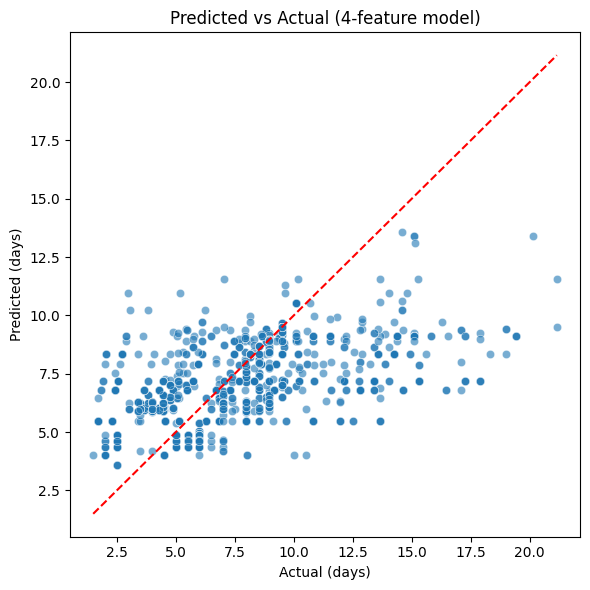

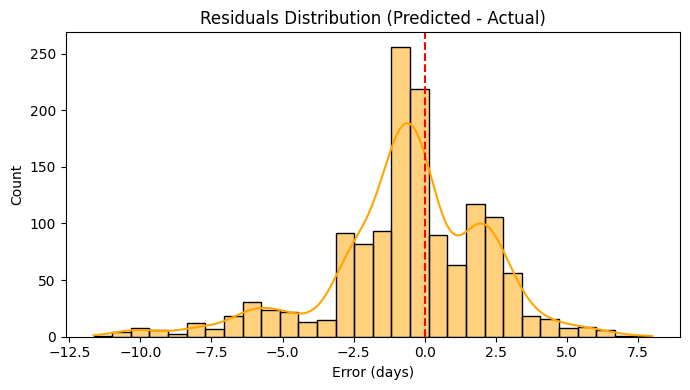

In [10]:
# -------------------------------------------------------
# 6️⃣ Visualization
# -------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
sns.scatterplot(x=np.expm1(yte), y=y_pred, alpha=0.6)
plt.plot([np.expm1(yte).min(), np.expm1(yte).max()],
         [np.expm1(yte).min(), np.expm1(yte).max()], 'r--')
plt.xlabel("Actual (days)")
plt.ylabel("Predicted (days)")
plt.title("Predicted vs Actual (4-feature model)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
sns.histplot(y_pred - np.expm1(yte), bins=30, kde=True, color="orange")
plt.axvline(0, color="red", linestyle="--")
plt.title("Residuals Distribution (Predicted - Actual)")
plt.xlabel("Error (days)")
plt.tight_layout()
plt.show()

In [11]:
# -------------------------------------------------------
# 7️⃣ Inference function
# -------------------------------------------------------
def predict_deadline(items):
    out = []
    for it in items:
        df_one = pd.DataFrame([it])
        yhat = np.expm1(pipe.predict(df_one[safe_num_feats + safe_cat_feats]))[0]
        days = max(1, round(min(yhat, 180)))
        out.append({"predicted_deadline_days": int(days)})
    return out


In [15]:
# -------------------------------------------------------
# 8️⃣ Dummy tests
# -------------------------------------------------------
if __name__ == "__main__":
    dummy_items = [
        {"issuetype": "Bug", "priorityid": 1, "storypoint": 5, "project": "TKTI"},
        {"issuetype": "Story", "priorityid": 2, "storypoint": 8, "project": "Aurora"},
        {"issuetype": "Task", "priorityid": 4, "storypoint": 13, "project": "UserGrid"},
    ]

    preds = predict_deadline(dummy_items)
    for i, res in enumerate(preds, 1):
        print(f"{dummy_items[i-1]['project']} / {dummy_items[i-1]['issuetype']} "
              f"→ Predicted deadline: {res['predicted_deadline_days']} days")

TKTI / Bug → Predicted deadline: 9 days
Aurora / Story → Predicted deadline: 8 days
UserGrid / Task → Predicted deadline: 7 days
